In [1]:
from transformers import AutoTokenizer
import torch

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ColorJitter, ToTensor, Resize
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader
from datasets import load_dataset,ClassLabel,Value,concatenate_datasets,Features,Array2D
import matplotlib.pyplot as plt
import numpy as np

/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_diffusion_train = load_dataset("poloclub/diffusiondb","2m_first_10k")
dataset_diffusion_test = load_dataset("poloclub/diffusiondb","2m_random_5k")
dataset_imagenette = load_dataset("frgfm/imagenette","160px")

Found cached dataset diffusiondb (/home/hakim/.cache/huggingface/datasets/poloclub___diffusiondb/2m_first_10k/0.9.1/547894e3a57aa647ead68c9faf148324098f47f2bc1ab6705d670721de9d89d1)
100%|██████████| 1/1 [00:00<00:00, 164.87it/s]
Found cached dataset diffusiondb (/home/hakim/.cache/huggingface/datasets/poloclub___diffusiondb/2m_random_5k/0.9.1/547894e3a57aa647ead68c9faf148324098f47f2bc1ab6705d670721de9d89d1)
100%|██████████| 1/1 [00:00<00:00, 297.57it/s]
Found cached dataset imagenette (/home/hakim/.cache/huggingface/datasets/frgfm___imagenette/160px/1.0.0/38929285b8abcae5c1305418e9d8fea5dd6b189bbbd22caba5f5537c7fa0f01f)
100%|██████████| 2/2 [00:00<00:00, 425.36it/s]


In [3]:
dataset_fake_1 = load_dataset("imagefolder", data_dir='/home/hakim/Desktop/data/0/sd15_train/')
dataset_fake_2 = load_dataset("imagefolder", data_dir='/home/hakim/Desktop/data/0/sd20_train/')
dataset_real_1 = load_dataset("imagefolder", data_dir='/home/hakim/Desktop/data_2/1/test_subset/')
dataset_real_2 = load_dataset("imagefolder", data_dir='/home/hakim/Desktop/data_2/1/train/')

Resolving data files: 100%|██████████| 9000/9000 [00:00<00:00, 54804.82it/s]
Found cached dataset imagefolder (/home/hakim/.cache/huggingface/datasets/imagefolder/default-978fb707cc59151c/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)
Resolving data files: 100%|██████████| 9000/9000 [00:00<00:00, 30258.68it/s]
Found cached dataset imagefolder (/home/hakim/.cache/huggingface/datasets/imagefolder/default-c679bedf4163c9f4/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)
Resolving data files: 100%|██████████| 20000/20000 [00:00<00:00, 61473.92it/s] 
Found cached dataset imagefolder (/home/hakim/.cache/huggingface/datasets/imagefolder/default-c14a0d4b24c52528/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)
Resolving data files: 100%|██████████| 9000/9000 [00:00<00:00, 25706.05it/s]
Found cached dataset imagefolder (/home/hakim/.cache/huggingface/datasets/imagefolder/default-0b7c082736bbcb8d/0.0.0/37fbb85cc714a338bea574a

In [4]:
dataset_fake_1 = dataset_fake_1["train"]
dataset_fake_2 = dataset_fake_2["train"]
dataset_real_1 = dataset_real_1["train"].select(range(9000))
dataset_real_2 = dataset_real_2["train"]

In [6]:
train_real_1 = dataset_real_1.select(range(3000))
val_real_1 = dataset_real_1.select(range(3000,6000))
test_real_1 = dataset_real_1.select(range(6000,9000)) 

train_real_2 = dataset_real_2.select(range(3000))
val_real_2 = dataset_real_2.select(range(3000,6000))
test_real_2 = dataset_real_2.select(range(6000,9000)) 

In [7]:
train_I = dataset_imagenette["train"]
val_I = dataset_imagenette["validation"].select(range(1962))
test_I = dataset_imagenette["validation"].select(range(1962,3925)) 

In [8]:
train_db = dataset_diffusion_train["train"].select(range(9469))
val_db = dataset_diffusion_test["train"].select(range(1962))
test_db = dataset_diffusion_test["train"].select(range(1962,3925))

In [9]:
label_column = len(train_real_1) * [1]
train_real_1 = train_real_1.add_column("label",label_column)
val_real_1 = val_real_1.add_column("label",label_column)
test_real_1 = test_real_1.add_column("label",label_column)
train_real_2 = train_real_2.add_column("label",label_column)
val_real_2 = val_real_2.add_column("label",label_column)
test_real_2 = test_real_2.add_column("label",label_column)

In [10]:
label_column = len(train_real_1) * [0]
train_fake_1 = train_fake_1.add_column("label",label_column)
val_fake_1 = val_fake_1.add_column("label",label_column)
test_fake_1 = test_fake_1.add_column("label",label_column)
train_fake_2 = train_fake_2.add_column("label",label_column)
val_fake_2 = val_fake_2.add_column("label",label_column)
test_fake_2 = test_fake_2.add_column("label",label_column)

In [11]:
label_column = len(train_db) * [0]
train_db = train_db.add_column("label",label_column)
label_column = len(val_db) * [0]
val_db = val_db.add_column("label",label_column)
label_column = len(test_db) * [0]
test_db = test_db.add_column("label",label_column)

In [12]:
del_col = ['prompt','seed', 'step','cfg','sampler','width','height','user_name','timestamp','image_nsfw', 'prompt_nsfw']
train_db = train_db.remove_columns(del_col)
val_db = val_db.remove_columns(del_col)
test_db = test_db.remove_columns(del_col)

In [13]:
train_I = train_I.remove_columns("label")
val_I = val_I.remove_columns("label")
test_I = test_I.remove_columns("label")

In [14]:
label_column = len(train_I) * [1]
train_I = train_I.add_column("label",label_column)
label_column = len(val_I) * [1]
val_I = val_I.add_column("label",label_column)
label_column = len(test_I) * [1]
test_I = test_I.add_column("label",label_column)

In [15]:
train = concatenate_datasets([train_I,train_db,train_fake_1,train_fake_2,train_real_1,train_real_2])
val = concatenate_datasets([val_I,val_db,val_fake_1,val_fake_2,val_real_1,val_real_2])
test = concatenate_datasets([test_I,test_db,test_fake_1,test_fake_2,test_real_1,test_real_2])

In [16]:
jitter = Compose(
    [ ToTensor(),Resize((160,160))]
)

In [17]:
def transforms(examples):

    examples["pixel_values"] = [jitter(image.convert("RGB")) for image in examples["image"]]

    return examples

In [18]:
train_dataset = train.with_transform(transforms)
val_dataset = val.with_transform(transforms)
test_dataset = test.with_transform(transforms)

In [19]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set hyperparameters
num_epochs = 10
batch_size = 64
learning_rate = 0.001

In [20]:
def collate_fn(examples):

    images = []

    labels = []

    for example in examples:

        images.append((example["pixel_values"]))

        labels.append(example["label"])

    pixel_values = torch.stack(images)

    labels = torch.tensor(labels)

    return {"pixel_values": pixel_values, "label": labels}

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=batch_size,shuffle=True,num_workers=2)
val_dataloader =  DataLoader(val_dataset, collate_fn=collate_fn, batch_size=batch_size,shuffle=True,num_workers=2)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=batch_size,shuffle=True,num_workers=2)

In [21]:
model = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.fc.out_features = 2

In [22]:
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
tr = model.train()

In [24]:
train_accu = []
train_losses = []

def train(epoch,data):
    print('\nEpoch : %d'%epoch)
    correct = 0
    running_loss=0
    total=0
    for element in data:
        # Move input and label tensors to the device
        inputs = element["pixel_values"].to(device)
        labels = element["label"].to(device)

        # Zero out the optimizer
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss/len(data)
    accu=100.*correct/total

    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))


In [25]:
eval_losses=[]
eval_accu=[]

def val(data):
    correct = 0
    running_loss=0
    total=0
    with torch.no_grad():
      for element in data:
        
          inputs = element["pixel_values"].to(device)
          labels = element["label"].to(device)

        
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          running_loss += loss.item()

          _, predicted = outputs.max(1)
          total += labels.size(0)
          correct += predicted.eq(labels).sum().item()

    val_loss =running_loss/len(data)
    accu=100.*correct/total

    eval_accu.append(accu)
    eval_losses.append(val_loss)
    print('Val Loss: %.3f | Accuracy: %.3f'%(val_loss,accu))

In [26]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
epochs=10
for epoch in range(1,epochs+1):
  train(epoch,train_dataloader)
  val(val_dataloader)


Epoch : 1
Train Loss: 0.268 | Accuracy: 90.756
Val Loss: 0.240 | Accuracy: 90.473

Epoch : 2
Train Loss: 0.151 | Accuracy: 94.159
Val Loss: 0.258 | Accuracy: 89.915

Epoch : 3
Train Loss: 0.130 | Accuracy: 94.945
Val Loss: 0.312 | Accuracy: 87.296

Epoch : 4
Train Loss: 0.107 | Accuracy: 95.905
Val Loss: 0.212 | Accuracy: 92.106

Epoch : 5
Train Loss: 0.096 | Accuracy: 96.286
Val Loss: 0.229 | Accuracy: 91.378

Epoch : 6
Train Loss: 0.077 | Accuracy: 97.023
Val Loss: 0.237 | Accuracy: 91.591

Epoch : 7
Train Loss: 0.068 | Accuracy: 97.408
Val Loss: 0.280 | Accuracy: 90.379

Epoch : 8
Train Loss: 0.057 | Accuracy: 97.867
Val Loss: 0.304 | Accuracy: 90.630

Epoch : 9
Train Loss: 0.055 | Accuracy: 97.789
Val Loss: 0.284 | Accuracy: 91.485

Epoch : 10
Train Loss: 0.052 | Accuracy: 98.158
Val Loss: 0.275 | Accuracy: 90.769


In [28]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for element in test_dataloader:
          # Move input and label tensors to the device
        inputs = element["pixel_values"].to(device)
        labels = element["label"].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 92.02561848549541 %


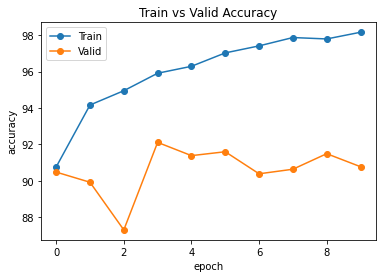

In [29]:
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

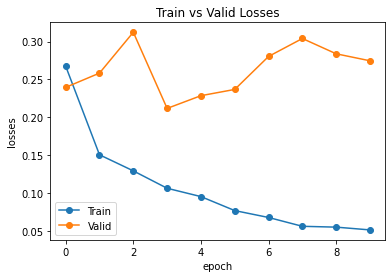

In [30]:
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [31]:
PATH = './extendend_dataset.pth'
torch.save(model.state_dict(), PATH)

In [33]:
classes = [0,1]
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for data in test_dataloader:
        inputs = data["pixel_values"].to(device)
        labels = data["label"].to(device)
        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: ',classname, "is " f'{accuracy:.1f} %')

Accuracy for class:  0 is 96.1 %
Accuracy for class:  1 is 87.9 %
